### Stage 1: Data Preparation

- [ ] Download [OpenEarthMap](https://zenodo.org/records/7223446) dataset using `zenodo-get` command
- [ ] Organise Metadata for OpenEarthMap dataset
- [ ] Create training, test, and validation splits
- [ ] Export Metadata as a CSV file

In [1]:
from pathlib import Path
from src.utils.common import read_yaml, show_config
from src import PARAMS_FILEPATH
from typing import List
from dataclasses import dataclass

@dataclass(frozen=True)
class DataConfig: 
    doi: str
    out_dir: Path
    train_test_val_split: List
    metadata_file: Path
    random_seed: int

class ConfigManager:
    def __init__(self, config_path = PARAMS_FILEPATH) -> None:
        self.config = read_yaml(config_path)

    def get_data_config(self) -> DataConfig:
        Path(self.config["out_dir"]).mkdir(parents=True, exist_ok=True)
        cfg = DataConfig(
            doi = self.config["doi"],
            out_dir = Path(self.config["out_dir"]),
            train_test_val_split = self.config["train_test_val_split"],
            metadata_file = Path(self.config["metadata_file"]),
            random_seed = self.config["random_seed"]
        )
        return cfg

cfg = ConfigManager().get_data_config()
show_config(cfg)

doi: 10.5281/zenodo.7223446
out_dir: data
train_test_val_split: [0.75, 0.15, 0.1]
metadata_file: data/metadata.csv
random_seed: 37


In [6]:
# Components
import os
import subprocess

class DataComponents:
    def __init__(self, cfg: DataConfig) -> None:
        self.config = cfg
    
    def download_data(self, unzip: bool = True, remove_zip: bool = False) -> None:
        print(f">>>>>>>>>>>> Downloading data from Zenodo <<<<<<<<<<<<")
        if not Path(self.config.out_dir).joinpath("OpenEarthMap_wo_xBD").exists() and not Path(self.config.out_dir).joinpath("OpenEarthMap.zip").exists():
            cmd = f"zenodo_get -e -d {self.config.doi} -o {self.config.out_dir}"
            subprocess.run(cmd, shell=True)
            if unzip:
                print(f"--> Unzipping data")
                cmd = f"unzip -q {self.config.out_dir}/OpenEarthMap.zip -d {self.config.out_dir}"
                subprocess.run(cmd, shell=True)
                if remove_zip:
                    os.remove(f"{self.config.out_dir}/OpenEarthMap.zip")
        else:
            print("--> Data already downloaded. Skipping.")
            
    def aggregate_data(self) -> None:
        from pathlib import Path
        print(f">>>>>>>>>>>> Aggregating data <<<<<<<<<<<<")
        # Aggregate Metadata
        imgs = sorted(list(Path(self.config.out_dir).joinpath("OpenEarthMap_wo_xBD").rglob('*/images/*.tif')))
        labels = sorted(list(Path(self.config.out_dir).joinpath("OpenEarthMap_wo_xBD").rglob('*/labels/*.tif')))

        self.images = []
        self.masks = []
        # Check if labels exist
        for img in imgs:
            for label in labels:
                if img.stem == label.stem:
                    self.images.append(img)
                    self.masks.append(label)
                    
        print(f"--> Number of images with labels: {len(self.images)}")
        
        # Delete images without labels
        for img in imgs:
            if img not in self.images:
                os.remove(img)
        for label in labels:
            if label not in self.masks:
                os.remove(label)
    
    def split_data(self) -> None:
        import pandas as pd
        print(f">>>>>>>>>>>> Splitting data into train/val/test sets <<<<<<<<<<<<")  
        from sklearn.model_selection import train_test_split

        meta = pd.DataFrame({"image": self.images, "mask": self.masks})

        # Assuming cfg.train_test_val_split is a list of three values summing to 1, e.g. [0.7, 0.2, 0.1]
        train_ratio, val_ratio, test_ratio = self.config.train_test_val_split

        # First split: separate train from the rest
        train_df, temp_df = train_test_split(meta, train_size=train_ratio, random_state=self.config.random_seed)

        # Second split: divide the rest into val and test
        val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
        val_df, test_df = train_test_split(temp_df, train_size=val_ratio_adjusted, random_state=self.config.random_seed)

        # Assign groups
        train_df["group"] = "train"
        val_df["group"] = "val"
        test_df["group"] = "test"
        
        print(f"--> Number of images in train/val/test sets: {len(train_df)}, {len(val_df)}, {len(test_df)}")

        # Combine
        self.metadata = pd.concat([train_df, val_df, test_df], axis=0)

        # Save
        self.metadata.to_csv(self.config.metadata_file, index=False)
        print(f"Metadata saved to {self.config.metadata_file}")

In [7]:
pipeline = DataComponents(ConfigManager().get_data_config())
pipeline.download_data(unzip=True, remove_zip=False)
pipeline.aggregate_data()
pipeline.split_data()

>>>>>>>>>>>> Downloading data from Zenodo <<<<<<<<<<<<
----------- Data already downloaded -----------
>>>>>>>>>>>> Aggregating data <<<<<<<<<<<<
Number of images with labels: 2687
>>>>>>>>>>>> Splitting data into train/val/test sets <<<<<<<<<<<<
Number of images in train/val/test sets: 2015, 403, 269
Metadata saved to data/metadata.csv


### Stage 2: Training and Evaluation

- [ ] Create DataLoader
- [ ] Initialise Model
- [ ] Train Model
- [ ] Evaluate Model

In [5]:
from dataclasses import dataclass
from src import PARAMS_FILEPATH
from pathlib import Path

@dataclass(frozen=True)
class Config:
    metadata_csv: Path
    models_dir: Path
    results_dir: Path
    logs_dir: Path
    architecture: str
    encoder: str
    encoder_weights: str
    n_classes: int
    n_channels: int
    epochs: int
    lr: float
    batch_size: int
    device: str
    num_workers: int
    resize_dimension: int
    apply_preprocessing: bool
    dev_run: bool
    tune_lr: bool
    checkpoint_path: Path
    encoder: str
    optimizer: str
    loss: str
    save_best_checkpoint: bool
    metric_threshold: float
    evaluate: bool
    save_predictions: bool
    
from src.utils.common import read_yaml, show_config

class ConfigManager:
    def __init__(self, params_filepath: Path = PARAMS_FILEPATH) -> None:
        self.config = read_yaml(params_filepath)
        if not Path(self.config.models_dir).exists(): Path(self.config.models_dir).mkdir(parents=True, exist_ok=True)
        if not Path(self.config.logs_dir).exists(): Path(self.config.logs_dir).mkdir(parents=True, exist_ok=True)
        if not Path(self.config.results_dir).exists(): Path(self.config.results_dir).mkdir(parents=True, exist_ok=True)
        
    def get_config(self) -> Config:
        params = self.config
        cfg = Config(
            models_dir=Path(params.models_dir),
            results_dir=Path(params.results_dir),
            metadata_csv=Path(params.metadata_file),
            logs_dir=Path(params.logs_dir),
            architecture=params.architecture,
            encoder=params.encoder,
            encoder_weights=params.encoder_weights,
            n_classes=params.n_classes,
            n_channels=params.n_channels,
            epochs=params.epochs,
            lr=params.lr,
            batch_size=params.batch_size,
            device=params.device,
            num_workers=params.num_workers,
            resize_dimension=params.resize_dimension,
            dev_run=params.dev_run,
            tune_lr=params.tune_lr,
            apply_preprocessing=params.apply_preprocessing,
            checkpoint_path=None if params.checkpoint_path == 'None' else Path(params.checkpoint_path),
            optimizer=params.optimizer,
            loss=params.loss,
            save_best_checkpoint=params.save_best_checkpoint,
            metric_threshold=params.metric_threshold,
            evaluate=params.evaluate,
            save_predictions=params.save_predictions
        )
        return cfg
        
cfg = ConfigManager().get_config()
show_config(cfg)

metadata_csv: metadata.csv
models_dir: models
results_dir: results
logs_dir: logs
architecture: DeepLabV3Plus
encoder: efficientnet-b0
encoder_weights: imagenet
n_classes: 9
n_channels: 3
epochs: 100
lr: 0.04
batch_size: 16
device: auto
num_workers: 24
resize_dimension: 512
apply_preprocessing: False
dev_run: False
tune_lr: True
checkpoint_path: logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=74-val_f1=0.56.ckpt
optimizer: adamax
loss: DiceLoss
save_best_checkpoint: True
metric_threshold: 0.56
evaluate: True
save_predictions: True


In [6]:
# Components
from src.utils.dataloader import OEMDataModule, get_training_augmentation, get_preprocessing, get_preprocessing_function
from src.utils.model import SegmentationModel
from src.utils.common import save_json
from src.utils.plotting import plot_test_batch
import pytorch_lightning as pl
import torch
import os
import warnings; warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision('medium')

class Components:
    def __init__(self, config: Config) -> None:
        self.config = config
        
    def create_dataloaders(self):
        print(f'------------- Creating Dataloaders -------------')
        if self.config.apply_preprocessing:
            print('------------->>> Applying Preprocessing <<<-------------')
            self.dm = OEMDataModule(
                metadata_csv=self.config.metadata_csv,
                augmentation=get_training_augmentation(),
                preprocessing=get_preprocessing(get_preprocessing_function(self.config.encoder, self.config.encoder_weights)),
                batch_size=self.config.batch_size,
                num_workers=self.config.num_workers,
                resize_dimensions=self.config.resize_dimension
            )
        else:
            print('------------->>> Skipping: Applying Preprocessing <<<-------------')
            self.dm = OEMDataModule(
                metadata_csv=self.config.metadata_csv,
                augmentation=get_training_augmentation(),
                preprocessing=None,
                batch_size=self.config.batch_size,
                num_workers=self.config.num_workers,
                resize_dimensions=self.config.resize_dimension
            )
    
    def initialise_model(self):
        print(f'------------- Inistialising Model: Architecture: {self.config.architecture} | Encoder: {self.config.encoder} | Encoder Weights: {self.config.encoder_weights} -------------')
        self.model = SegmentationModel(
            architecture=self.config.architecture,
            n_channels=self.config.n_channels,
            n_classes=self.config.n_classes,
            lr=self.config.lr,
            encoder=self.config.encoder,
            encoder_weights=self.config.encoder_weights,
            loss=self.config.loss,
            optimizer=self.config.optimizer,
        )
    
    def load_checkpoint(self):
        if self.config.checkpoint_path is not None and os.path.exists(self.config.checkpoint_path):
            print('------------- Loading Checkpoint -------------')
            print(f'Loading checkpoint from {self.config.checkpoint_path}')
            try:
                self.model = SegmentationModel.load_from_checkpoint(self.config.checkpoint_path, hparams_file='params.yaml')
                print('Checkpoint loaded successfully')
            except Exception as e:
                print(f'Failed to load checkpoint: {e}')

    
    def create_callbacks(self):
        print('------------- Creating Callbacks -------------')
        ### Define Checkpoints for Early Stopping, Tensorboard Summary Writer, and Best Checkpoint Saving
        from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
        from pytorch_lightning.loggers import TensorBoardLogger

        # Early stopping callback
        self.early_stopping = EarlyStopping(
            monitor='val_loss',  # Metric to monitor
            patience=10,          # Number of epochs with no improvement after which training will be stopped
            verbose=True,
            mode='min'           # Mode can be 'min' for minimizing the monitored metric or 'max' for maximizing it
        )

        # Model checkpoint callback
        self.checkpoint_callback = ModelCheckpoint(
            monitor='val_f1',   # Metric to monitor
            filename='{epoch:02d}-{val_f1:.2f}',  # Filename format
            save_top_k=1,         # Save the top k models
            mode='max',           # Mode can be 'min' or 'max'
            verbose=True,
            dirpath=self.config.logs_dir.joinpath(f'{self.config.architecture}_{self.config.encoder}/checkpoints')
        )

        # TensorBoard logger
        self.tensorboard_logger = TensorBoardLogger(
            save_dir=self.config.logs_dir,     # Directory to save the logs
            name=f"{self.config.architecture}_{self.config.encoder}"       # Experiment name
        )

        from pytorch_lightning.callbacks import LearningRateMonitor
        # Learning rate monitor
        self.lr_monitor = LearningRateMonitor(logging_interval='epoch')
        
    def tune_lr(self):
        if self.config.tune_lr:
            from pytorch_lightning.tuner.tuning import Tuner
            print('------------- Tunning Learning Rate -------------')
            # Define a separate trainer for hyperparameter tuning
            self.tuning_trainer = pl.Trainer(
                accelerator=self.config.device,
                precision="16-mixed",
                logger=self.tensorboard_logger,
                callbacks=None,
                max_epochs=5  # Set this to a low number for faster tuning
            )

            self.dm.setup('fit')

            # Hyperparameter tuning
            self.tuner = Tuner(self.tuning_trainer)
            self.new_lr = self.tuner.lr_find(self.model, train_dataloaders=self.dm.train_dataloader(), val_dataloaders=self.dm.val_dataloader()).suggestion()
            print(f'Suggested learning rate: {self.new_lr}')
        else:
            print('------------- Skipping Tunning Learning Rate -------------')
        
    def create_trainer(self):
        print(f'------------- Training Model: {self.config.architecture} with {self.config.encoder} Encoder -------------')
        self.trainer = pl.Trainer(
            accelerator=self.config.device,
            max_epochs=self.config.epochs,
            precision="16-mixed",
            logger= self.tensorboard_logger if hasattr(self, 'tensorboard_logger') else None,
            callbacks=[self.early_stopping, self.checkpoint_callback, self.lr_monitor],
            enable_progress_bar=True,
            fast_dev_run=self.config.dev_run,
        )
    
    def train(self):
        print('------------- Training Started -------------')
        self.dm.setup('fit')
        if self.config.checkpoint_path is not None and os.path.exists(self.config.checkpoint_path):
            print(f'Resuming training from checkpoint: {self.config.checkpoint_path}')
            self.trainer.fit(model=self.model, train_dataloaders=self.dm.train_dataloader(), val_dataloaders=self.dm.val_dataloader(), ckpt_path=self.config.checkpoint_path)
        else:
            self.trainer.fit(model=self.model, train_dataloaders=self.dm.train_dataloader(), val_dataloaders=self.dm.val_dataloader())
        print('------------- Training Completed -------------')
        
        # Save Model
        if self.config.save_best_checkpoint and self.metrics['val_f1'] > self.config.metric_threshold:
            print('------------- Saving Model -------------')
            self.model.save(Path(self.config.models_dir).joinpath('best_model.ckpt')) 
        
    # Loading the best checkpoint
    def load_model(self):
        if self.config.checkpoint_path is not None and Path(self.config.checkpoint_path).exists():
            print('------------- Loading Checkpoint -------------')
            print(f'Loading checkpoint from {self.config.checkpoint_path}')
            try:
                self.model = SegmentationModel.load_from_checkpoint(self.config.checkpoint_path)
                print('Checkpoint loaded successfully')
            except Exception as e:
                print(f'Failed to load checkpoint: {e}')
                
    def evaluate(self):
        print('------------- Evaluating Model -------------')
        self.dm.setup('test')
        try:
            test_results = self.trainer.test(model=self.model, dataloaders=self.dm.test_dataloader())
            
            # Extract relevant metrics from test_results
            # Assuming test_results is a list of dictionaries and contains y_true and y_pred
            self.metrics = test_results[0] if test_results else {}
            self.metrics_filepath = Path(self.config.results_dir).joinpath('metrics.json')
            # Save metrics to a file
            print(f'Saving metrics to: {self.metrics_filepath}')
            save_json(Path(self.config.metrics_filepath), self.metrics)  # Save the metrics to a file
            
            # Save Model as ONNX
            if self.metrics['test_f1'] > self.config.metric_threshold:
                print(f"Test F1-Score ({self.metrics['test_f1']:.3f}) above threshold ({self.config.metric_threshold}), saving model as ONNX...")
                save_path = Path(self.config.models_dir).joinpath(f"{Path(self.config.checkpoint_path).parent.parent.name}.onnx")
                print(f'Saving model to: {save_path}')
                test_dataloader = self.dm.test_dataloader()
                input_sample, _ = next(iter(test_dataloader))
                input_sample = input_sample[0].unsqueeze(0)
                self.model.to_onnx(save_path, input_sample=input_sample, export_params=True)
            
        except Exception as e:
            print(f"An error occurred: {e}")
            
    def save_predictions(self):
        if self.config.save_predictions:
            print('------------- Predicting on Test Batch and Saving Predictions -------------')
            plot_test_batch(
                pipeline=self, 
                randomised=False, 
                savefig_path=Path(self.config.results_dir).joinpath(f"{Path(self.config.checkpoint_path).parent.parent.name}_predictions.png")
            )

ImportError: cannot import name 'save_json' from 'src.utils.common' (/mnt/e/Research/dvc/OpenEarthMap/src/utils/common.py)

In [3]:
# pipeline = Components(config=ConfigManager().get_config())
# pipeline.create_dataloaders()

------------- Creating Dataloaders -------------
------------->>> Skipping: Applying Preprocessing <<<-------------


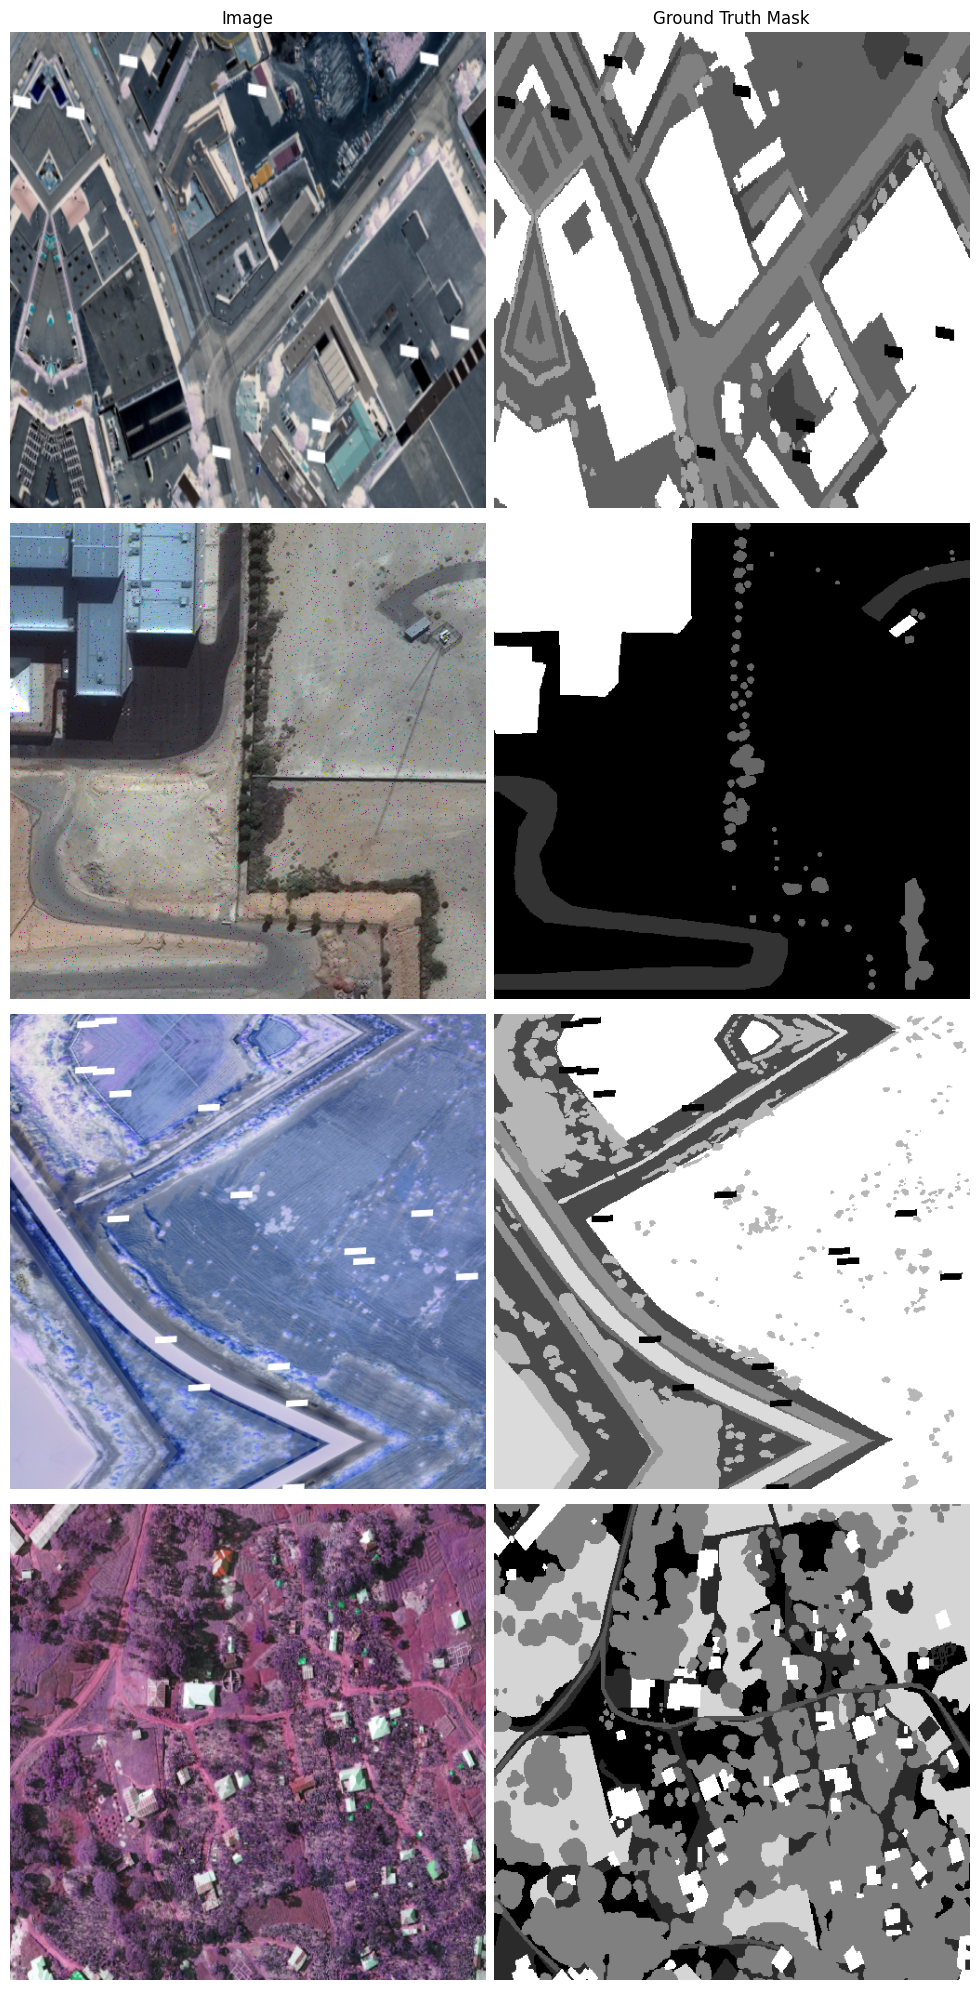

In [4]:
# from src.utils.plotting import plot_train_batch
# plot_train_batch(dm=pipeline.dm, randomised=False)

In [5]:
pipeline = Components(config=ConfigManager().get_config())
pipeline.create_dataloaders()
if pipeline.config.evaluate and Path(pipeline.config.checkpoint_path).exists():
    # Evaluate the model
    pipeline.load_model()
    pipeline.create_trainer()
    pipeline.evaluate()
    if pipeline.config.save_predictions:
        pipeline.save_predictions()
else:
    # Train the model
    pipeline.initialise_model()
    if pipeline.config.checkpoint_path is not None and Path(pipeline.config.checkpoint_path).exists():
        pipeline.load_checkpoint()
    pipeline.create_callbacks()
    if pipeline.config.tune_lr:
        pipeline.tune_lr()
    pipeline.create_trainer()
    pipeline.train()

------------- Inistialising Model: Architecture: DeepLabV3Plus | Encoder: efficientnet-b0 | Encoder Weights: imagenet -------------
------------- Loading Checkpoint -------------
Loading checkpoint from logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=09-val_f1=0.53.ckpt
Checkpoint loaded successfully
------------- Creating Callbacks -------------
------------- Tunning Learning Rate -------------


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.02089296130854041
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /mnt/e/Research/dvc/OpenEarthMap/.lr_find_645bf11e-9dfd-4371-a8f1-53e839d7513b.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /mnt/e/Research/dvc/OpenEarthMap/.lr_find_645bf11e-9dfd-4371-a8f1-53e839d7513b.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=09-val_f1=0.53

Suggested learning rate: 0.02089296130854041
------------- Training Model: DeepLabV3Plus with efficientnet-b0 Encoder -------------
------------- Training Started -------------
Resuming training from checkpoint: logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=09-val_f1=0.53.ckpt


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | model   | DeepLabV3Plus | 4.9 M  | train
1 | loss_fn | DiceLoss      | 0      | train
--------------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.638    Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=09-val_f1=0.53.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 1375: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 1500: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 1625: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.513
INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 1750: 'val_f1' reached 0.53214 (best 0.53214), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=13-val_f1=0.53.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 1875: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 2000: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 2125: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 2250: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 2375: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 2500: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.494
INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 2625: 'val_f1' reached 0.53334 (best 0.53334), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=20-val_f1=0.53.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.484
INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 2750: 'val_f1' reached 0.53961 (best 0.53961), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=21-val_f1=0.54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 2875: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 3000: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 3125: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.483
INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 3250: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 3375: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.467
INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 3500: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 3625: 'val_f1' reached 0.54389 (best 0.54389), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=28-val_f1=0.54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 3750: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 3875: 'val_f1' reached 0.55567 (best 0.55567), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=30-val_f1=0.56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.464
INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 4000: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 4125: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 4250: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.456
INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 4375: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 4500: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 4625: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 4750: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.452
INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 4875: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.445
INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 5000: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 5125: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 5250: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.442
INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 5375: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 5500: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 5625: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.437
INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 5750: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 5875: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 6000: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 6125: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 6250: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 6375: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 6500: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.429
INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 6625: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.423
INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 6750: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 6875: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 7000: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 7125: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.418
INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 7250: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 7375: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 7500: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 7625: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 7750: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 7875: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.413
INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 8000: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 8125: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.411
INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 8250: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 8375: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 8500: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 8625: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 8750: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 8875: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 9000: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.402
INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 9125: 'val_f1' reached 0.55688 (best 0.55688), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=72-val_f1=0.56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 9250: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 9375: 'val_f1' reached 0.56106 (best 0.56106), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=74-val_f1=0.56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 9500: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 9625: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 9750: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 9875: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.401
INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 10000: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 10125: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.398
INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 10250: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 10375: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 10500: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 84, global step 10625: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 85, global step 10750: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 86, global step 10875: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 87, global step 11000: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 88, global step 11125: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 11250: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 90, global step 11375: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.398. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 91, global step 11500: 'val_f1' was not in top 1


------------- Training Completed -------------


In [6]:
pipeline.dm.setup("test")
pipeline.trainer.test(dataloaders=pipeline.dm.test_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=74-val_f1=0.56.ckpt


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=74-val_f1=0.56.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.5588818788528442     │
│          test_f2          │     0.559563934803009     │
│         test_iou          │    0.47622957825660706    │
│         test_loss         │    0.42211517691612244    │
│      test_precision       │     0.665394127368927     │
│        test_recall        │    0.6451280117034912     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.42211517691612244,
  'test_iou': 0.47622957825660706,
  'test_f1': 0.5588818788528442,
  'test_f2': 0.559563934803009,
  'test_precision': 0.665394127368927,
  'test_recall': 0.6451280117034912}]

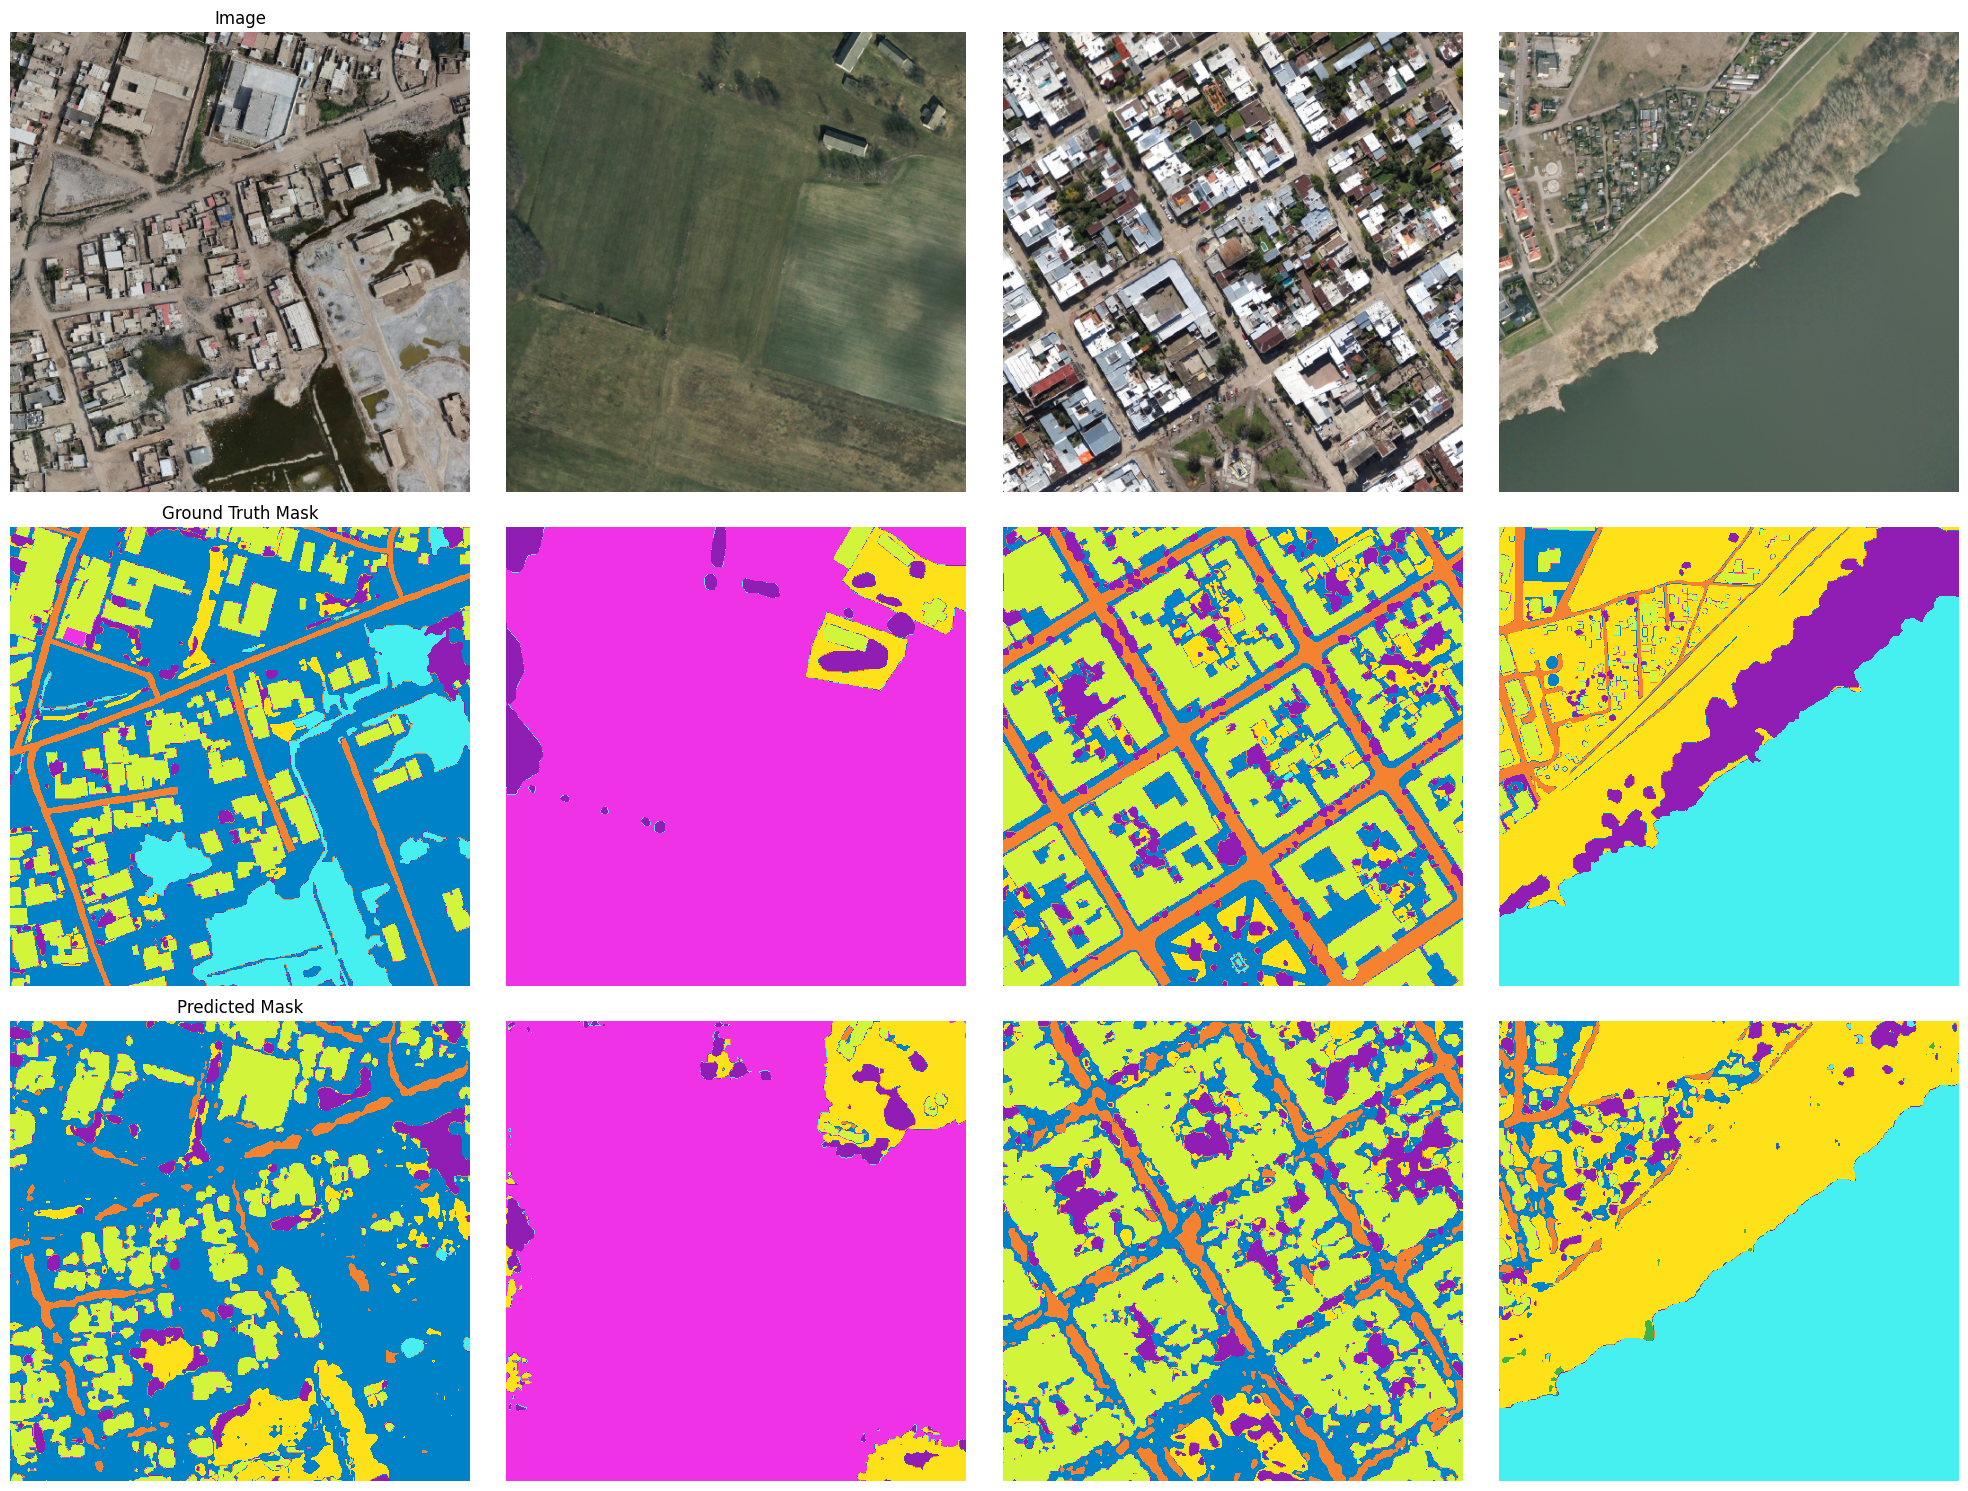

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.colors import ListedColormap

# Define a discrete colormap with nine distinct colors
cmap = ListedColormap([
    '#e6194b', '#3cb44b', '#ffe119', '#0082c8',
    '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#d2f53c'
])

# Assuming the test dataloader and model setup as in the previous context
pipeline.dm.setup('test')

# Get the test dataloader
test_dataloader = pipeline.dm.test_dataloader()
test_dataloader_list = list(test_dataloader)

# Randomly select a batch of data
x, y = random.choice(test_dataloader_list)

# Put the model in evaluation mode
pipeline.model.eval()

# Disable gradients for this step
with torch.no_grad():
    # Pass the data through the model
    y_hat = pipeline.model(x)  # Ensure this is on the correct device if necessary

# Get the predicted mask by taking the argmax across the class dimension
predicted_mask = torch.argmax(y_hat, dim=1).cpu().numpy()

# Plot the results
fig, axs = plt.subplots(3, 4, figsize=(20, 15))  # 3 rows: image, ground truth, predicted mask
for i in range(4):
    # Plot the image
    image = np.transpose(x[i][:3, :, :], (1, 2, 0))
    axs[0, i].imshow(image)
    axs[0, i].axis('off')
    if i == 0:
        axs[0, i].set_title('Image')
    
    # Plot the ground truth mask
    ground_truth_mask = y[i][0].cpu().numpy()
    axs[1, i].imshow(ground_truth_mask, cmap=cmap, vmin=0, vmax=8)
    axs[1, i].axis('off')
    if i == 0:
        axs[1, i].set_title('Ground Truth Mask')

    # Plot the predicted mask
    axs[2, i].imshow(predicted_mask[i], cmap=cmap, vmin=0, vmax=8)
    axs[2, i].axis('off')
    if i == 0:
        axs[2, i].set_title('Predicted Mask')

plt.tight_layout()
plt.show()

In [ ]:
### Save Model Checkpoint to Models Folder

def 